# Make anaphase time predictions based on the instataneous surface only with a linear regression model

First attempt to predict the anaphase time based on the time series of the relative surface feature only. We will use simple simple machine learning algorithms to make our predictions as a first attempt. Here we use univariate linear regression as a model.

Problem formulation $\forall$ division event $i$, $\forall 0< t < t^*$, we want to predict the target variable $y_{i, t} = t_i^* - t$ , the relative time to anaphase(TTA), based on the present feature, $X_{i, t}$ ; i.e. we want $$f : X_{i, t} \mapsto y_{i, t} = t_i^* - t \in \mathbb{R_+^*}$$

This is regression problem, and we will use the classical MSE as a loss function/evaluation metrics.

In [2]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

## Loading Data

In [23]:
os.chdir("D:\Documents\STAGE\Anaphase")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

(495, 13)


,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf
idx,,,,,,,,,,,,,
0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000
0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842
0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853
0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912
0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739


## Linear regression on the relative surface

Here we will try to fit a linear regression to predict the TTA given the cumulative relative surface at time $t$. This is a dumb regressor, as it will not be bad on average, but learns to predict from single data points (i.e. makes the assumption that all the observations are i.i.d.) instead of taking the cell's history into account and trying to predict, at each time step of a time series, the TTA. As we will see, it will not perform bad on average (RMSE of 5 minutes) and will simply make early predictions on the points that are over the curve (latecomers) and late observations on the points which are under the curve (earlycomers). 

### Training

In [44]:
# prepare the training set
from sklearn.model_selection import train_test_split

# features = ["relat_surf", "time"]
# for f in features:
#     data[f] = (data[f] - data[f].mean()) / data[f].std()

features = ["surf_x_time"]
data["surf_x_time"] = 20 * data["relat_surf"] + data["time"]
data["surf_x_time"] = (data["surf_x_time"] - data["surf_x_time"].mean()) / data["surf_x_time"].std()

X, y = data[features].values.reshape(-1, 1), data["time_to_anaphase"].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(445, 1) (50, 1) (445, 1) (50, 1)


In [56]:
from sklearn.linear_model import LinearRegression

lm = RandomForestRegressor(max_depth=5).fit(X_train, y_train)

print(f"R^2 coefficient : {round(lm.score(X_train, y_train), 2)}")

C:\Users\Hugo\anaconda3\envs\deep_learning.py\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


R^2 coefficient : 0.84


Text(0.5, 1.0, 'Linear regression predictions on the training set')

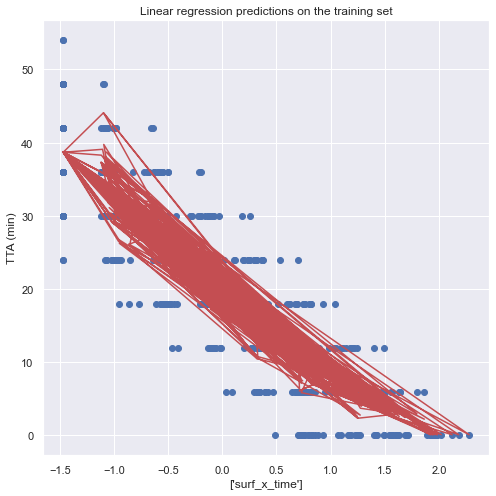

In [57]:
predictions_on_train_set = lm.predict(X_train)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_train, y_train, c='b', label="Train set")
ax.plot(X_train, predictions_on_train_set, c="r", label="Predictions")
ax.set_xlabel(features)
ax.set_ylabel("TTA (min)")
ax.set_title("Linear regression predictions on the training set")

In [58]:
print(f"Regression equation : {lm.coef_[0]} * daughter_surface + {lm.intercept_}")

AttributeError: 'RandomForestRegressor' object has no attribute 'coef_'

### Evaluation

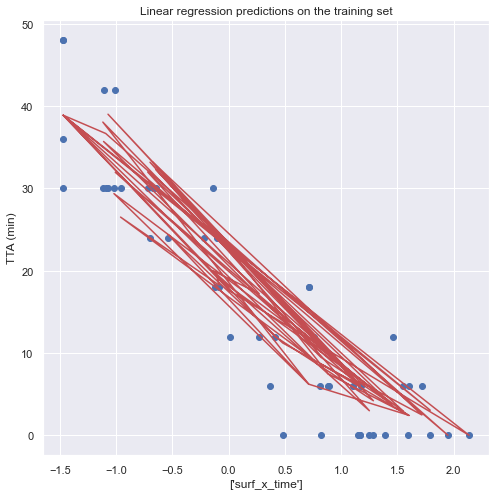

In [54]:
predictions_on_test_set = lm.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_test, y_test, c='b', label="Test set")
ax.plot(X_test, predictions_on_test_set, c="r", label="Predictions")
ax.set_xlabel(features)
ax.set_ylabel("TTA (min)")
ax.set_title("Linear regression predictions on the training set")
plt.savefig("Linear Regression", format="pdf")

RMSE : 19.625627398530515


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1 but corresponding boolean dimension is 50

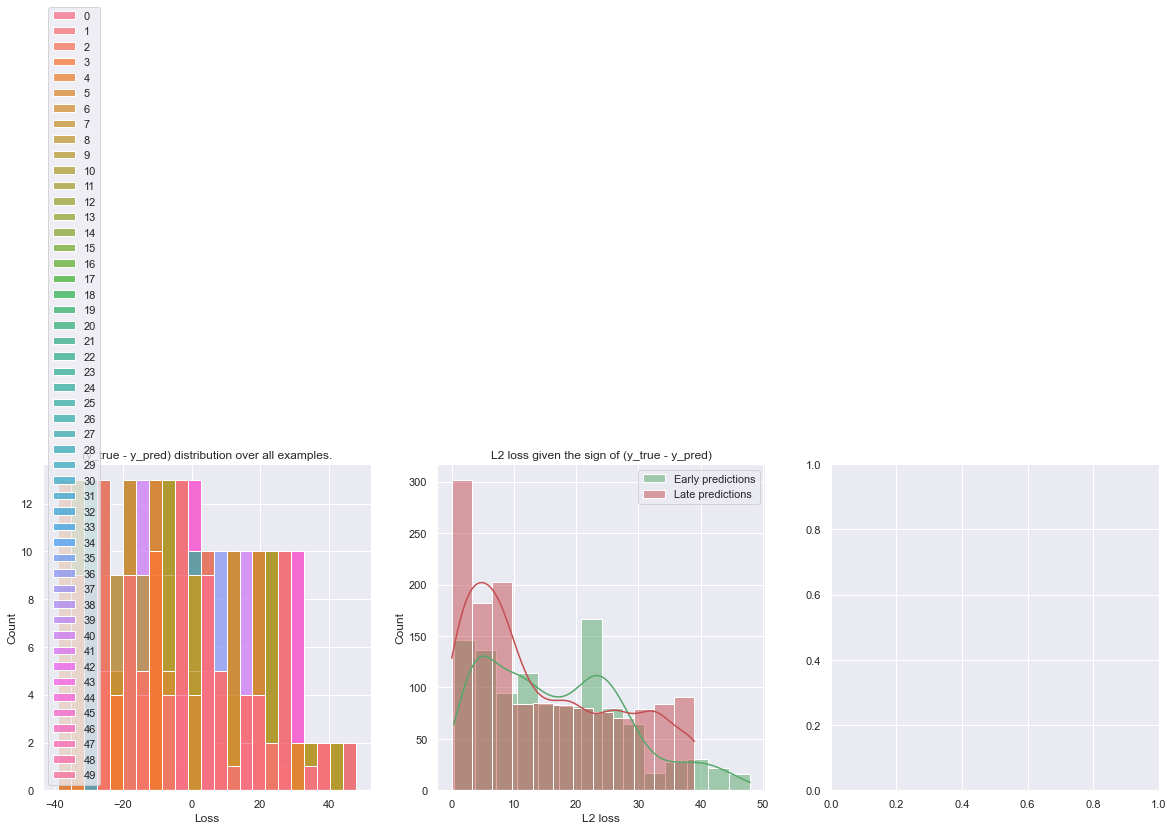

In [55]:
# evaluation with the clasical RMSE
signed_losses = (y_test - predictions_on_test_set) 
losses = signed_losses ** 2
print(f"RMSE : {np.sqrt(losses.mean())}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RMSE distribution
sns.histplot(signed_losses, ax=axes[0])
axes[0].set_title("(y_true - y_pred) distribution over all examples.")
axes[0].set_xlabel("Loss")

# Conditional distributions given the sign of the error
sns.histplot(np.sqrt(losses[signed_losses >= 0]), color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(np.sqrt(losses[signed_losses < 0]), color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("L2 loss")
axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

# conditional distributions of the points
axes[2].scatter(X_test[signed_losses >= 0], y_test[signed_losses >= 0], c="g", label="Early predictions")
axes[2].scatter(X_test[signed_losses < 0], y_test[signed_losses < 0], c="r", label="Late predictions")
axes[2].plot(X_test, predictions_on_test_set, c="black", label="Linear regression curve")
axes[2].legend()
axes[2].set_xlabel(features)
axes[2].set_ylabel("TTA (min)")
axes[2].set_title("Observations given the sign of (y_true - y_pred)")
plt.savefig("Linear Reg errors", format="pdf")

### Diagnostic plots

No handles with labels found to put in legend.
C:\Users\Hugo\anaconda3\envs\deep_learning.py\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice.
C:\Users\Hugo\anaconda3\envs\deep_learning.py\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Autocorrelogram of residuals')

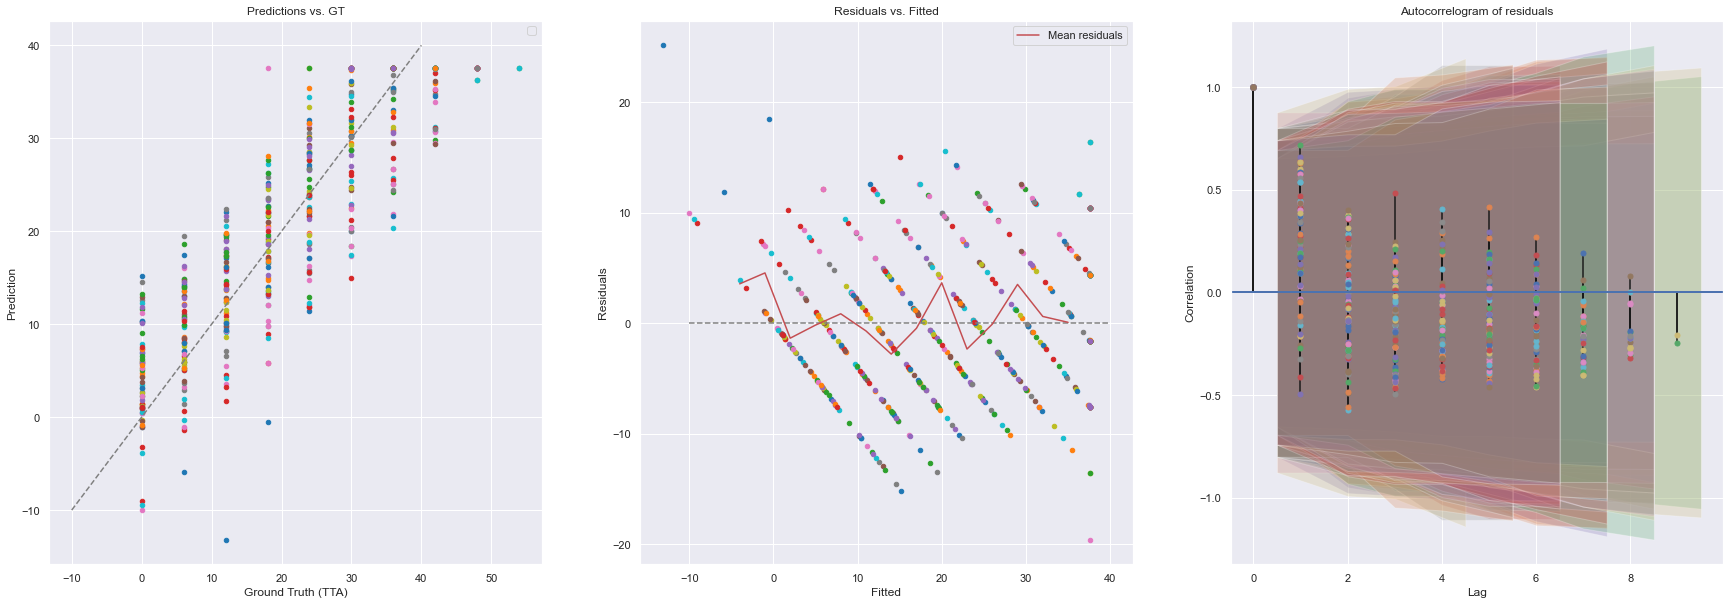

In [74]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

import matplotlib.colors as mcolors
by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in mcolors.TABLEAU_COLORS.items()]
names = [name for hsv, name in by_hsv]

predictions = lm.predict((data[features].values.reshape(-1, 1) - data[features].values.mean()) / data[features].values.std())

# Predictions vs. GT
for p, gt, idx in zip(predictions, data["time_to_anaphase"], data.index):
    if idx < 100:
        ax[0].plot(gt, p, ".", c=names[idx % len(names)], ms=9)
ax[0].plot([-10, 40], [-10, 40], "--", c="grey")
ax[0].legend()

ax[0].set_xlabel("Ground Truth (TTA)")
ax[0].set_ylabel("Prediction")
ax[0].set_title("Predictions vs. GT")

# Residuals vs. Fitted
means = []
intervals = np.arange(-10, 40, 3)
for k in intervals:
    predictions_here = []
    for p, gt in zip(predictions, data["time_to_anaphase"].values):
        if k <= p and p  < k+1:
            predictions_here.append(gt - p)
    means.append(np.array(predictions_here).mean())

for p, gt, idx in zip(predictions, data["time_to_anaphase"], data.index):
    if idx < 100:
        ax[1].plot(p, gt - p, ".", c=names[idx % len(names)], ms=9)
ax[1].plot([-10, 40], [0, 0], "--", c="grey")
ax[1].plot([k for k in range(-10, 40, 3)], means, "r", label="Mean residuals")
ax[1].legend()

ax[1].set_xlabel("Fitted")
ax[1].set_ylabel("Residuals")
ax[1].set_title("Residuals vs. Fitted")

# autocorrelation plot
from statsmodels.graphics.tsaplots import plot_acf
data["predictions"] = predictions
for idx in data.index.unique():
    traj = data.loc[idx]
    plot_acf(traj["time_to_anaphase"] - traj["predictions"], ax=ax[2])
    
ax[2].set_xlabel("Lag")
ax[2].set_ylabel("Correlation")
ax[2].set_title("Autocorrelogram of residuals")

### Save predictions

In [14]:
predictions = []
for i, row in data.iterrows():
    if row["time_to_anaphase"] >= 0:
        p = lm.predict(np.array(row["relat_surf"]).reshape(-1, 1))
        predictions.append(p[0])
    else:
        predictions.append(-1)
        
data["predictions_tta"] = predictions

data[:50]

,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,relat_surf_standardized,predictions_tta
0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,0.000000,37.417033
1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,0.000280,37.401585
2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,0.001067,37.358559
3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,0.001550,37.332389
4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,0.002038,37.306070
5,0,5,30,462.524165,226.197183,456.493388,242.023256,226.446179,81.848088,0.361446,False,0,6,0.181476,0.002463,37.283668
6,0,6,36,461.312897,226.070423,454.310524,242.285714,219.446179,98.995175,0.451114,True,1,0,0.218778,0.003094,37.250583
11,1,11,0,473.698778,241.550725,-1.000000,-1.000000,192.583462,0.000000,0.000000,False,0,42,0.000000,0.000000,37.417033
12,1,12,6,471.727764,241.550725,466.226769,254.521739,186.299153,18.397072,0.098750,False,0,36,0.048556,0.000660,37.380596
13,1,13,12,471.480831,241.850746,466.521687,255.606061,183.867756,40.691246,0.221307,False,0,30,0.104999,0.001490,37.335376


In [ ]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data.to_csv(f"LinReg_Predictions_{features}_BF_f0001-1-100.csv", sep=";")

contours

## Linear regression on the elapsed time since the bud was first detected

Here we will try to fit a linear regression to predict the TTA given the cumulative relative surface at time $t$. This is a dumb regressor, as it will not be bad on average, but learns to predict from single data points (i.e. makes the assumption that all the observations are i.i.d.) instead of taking the cell's history into account and trying to predict, at each time step of a time series, the TTA. As we will see, it will not perform bad on average (RMSE of 5 minutes) and will simply make early predictions on the points that are over the curve (latecomers) and late observations on the points which are under the curve (earlycomers). 

### Training

In [49]:
from sklearn.model_selection import train_test_split
features = "time"

X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["time_to_anaphase"].values, train_size=0.9)
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(445, 1) (50, 1) (445,) (50,)


In [50]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression().fit(X_train, y_train)

print(f"R^2 coefficient : {round(lm.score(X_train, y_train), 2)}")

R^2 coefficient : 0.75


Text(0.5, 1.0, 'Linear regression predictions on the training set')

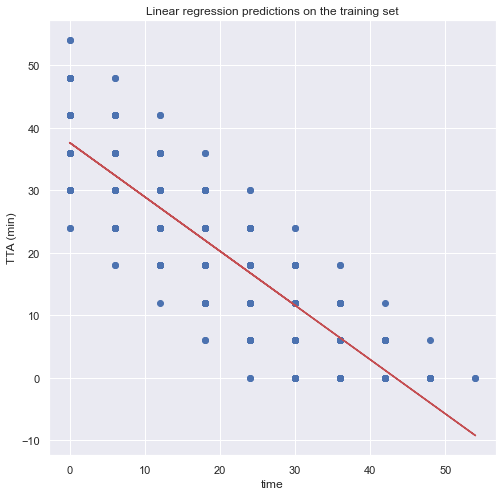

In [51]:
predictions_on_train_set = lm.predict(X_train)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_train, y_train, c='b', label="Train set")
ax.plot(X_train, predictions_on_train_set, c="r", label="Predictions")
ax.set_xlabel(features)
ax.set_ylabel("TTA (min)")
ax.set_title("Linear regression predictions on the training set")

In [52]:
print(f"Regression equation : {lm.coef_[0]} * daughter_surface + {lm.intercept_}")

Regression equation : -0.8675010663556308 * daughter_surface + 37.623965257567356


### Evaluation

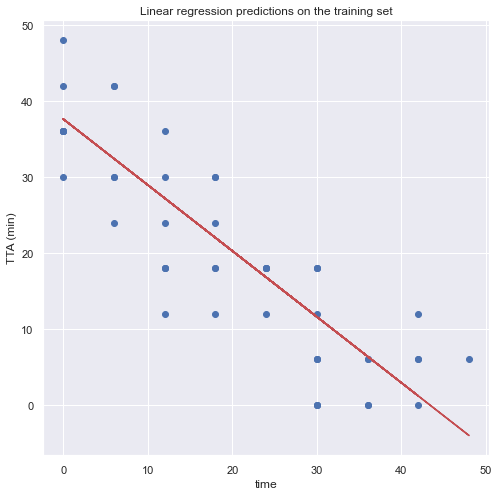

In [53]:
predictions_on_test_set = lm.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_test, y_test, c='b', label="Test set")
ax.plot(X_test, predictions_on_test_set, c="r", label="Predictions")
ax.set_xlabel(features)
ax.set_ylabel("TTA (min)")
ax.set_title("Linear regression predictions on the training set")
plt.savefig("Linear Regression", format="pdf")

RMSE : 6.791544302842363


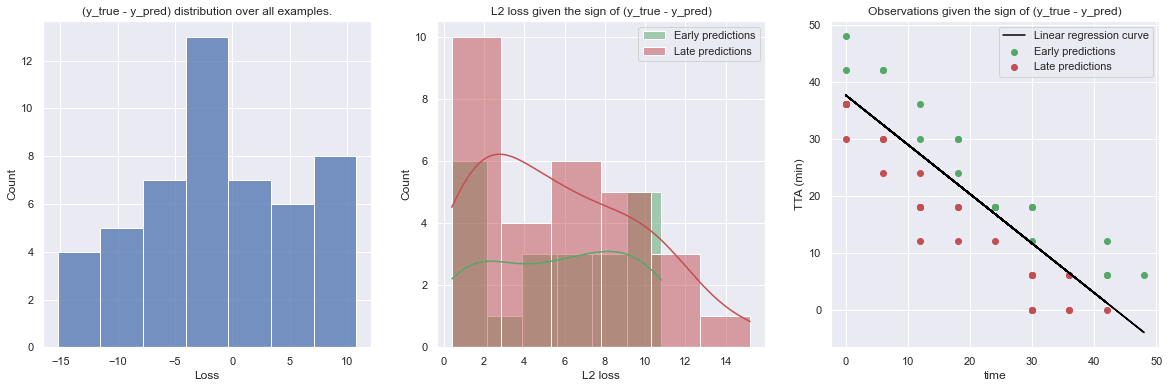

In [54]:
# evaluation with the clasical RMSE
signed_losses = (y_test - predictions_on_test_set) 
losses = signed_losses ** 2
print(f"RMSE : {np.sqrt(losses.mean())}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RMSE distribution
sns.histplot(signed_losses, ax=axes[0])
axes[0].set_title("(y_true - y_pred) distribution over all examples.")
axes[0].set_xlabel("Loss")

# Conditional distributions given the sign of the error
sns.histplot(np.sqrt(losses[signed_losses >= 0]), color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(np.sqrt(losses[signed_losses < 0]), color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("L2 loss")
axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

# conditional distributions of the points
axes[2].scatter(X_test[signed_losses >= 0], y_test[signed_losses >= 0], c="g", label="Early predictions")
axes[2].scatter(X_test[signed_losses < 0], y_test[signed_losses < 0], c="r", label="Late predictions")
axes[2].plot(X_test, predictions_on_test_set, c="black", label="Linear regression curve")
axes[2].legend()
axes[2].set_xlabel(features)
axes[2].set_ylabel("TTA (min)")
axes[2].set_title("Observations given the sign of (y_true - y_pred)")
plt.savefig("Linear Reg errors", format="pdf")

### Save predictions

In [14]:
predictions = []
for i, row in data.iterrows():
    if row["time_to_anaphase"] >= 0:
        p = lm.predict(np.array(row["relat_surf"]).reshape(-1, 1))
        predictions.append(p[0])
    else:
        predictions.append(-1)
        
data["predictions_tta"] = predictions

data[:50]

,idx,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,relat_surf_standardized,predictions_tta
0,0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000,0.000000,37.417033
1,0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,0.000280,37.401585
2,0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,0.001067,37.358559
3,0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,0.001550,37.332389
4,0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,0.002038,37.306070
5,0,5,30,462.524165,226.197183,456.493388,242.023256,226.446179,81.848088,0.361446,False,0,6,0.181476,0.002463,37.283668
6,0,6,36,461.312897,226.070423,454.310524,242.285714,219.446179,98.995175,0.451114,True,1,0,0.218778,0.003094,37.250583
11,1,11,0,473.698778,241.550725,-1.000000,-1.000000,192.583462,0.000000,0.000000,False,0,42,0.000000,0.000000,37.417033
12,1,12,6,471.727764,241.550725,466.226769,254.521739,186.299153,18.397072,0.098750,False,0,36,0.048556,0.000660,37.380596
13,1,13,12,471.480831,241.850746,466.521687,255.606061,183.867756,40.691246,0.221307,False,0,30,0.104999,0.001490,37.335376


In [ ]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data.to_csv(f"LinReg_Predictions_{features}_BF_f0001-1-100.csv", sep=";")

contours